<a href="https://colab.research.google.com/github/pranay5255/orbitshift/blob/main/OrbitShift_Assignment_Pranay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Torch and Transformers for training and fine tuning


In [44]:
!pip install transformers[torch] torch


#Importing relevant libraries

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import transformers
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
import pandas as pd
from tqdm.auto import tqdm
from transformers import DistilBertTokenizerFast,DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from huggingface_hub import notebook_login
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from transformers import DistilBertForSequenceClassification








#Please upload the sample assignment data  
# <<----

In [46]:
df = pd.read_csv("./classification_assignement_OrbitShift - classification_data.csv")


In [47]:
df

,title,label
0,"Director, Learning and Support",CLASS1
1,Customer Service Assistant,CLASS2
2,2023 Internship and Education Program Manageme...,CLASS13
3,Communications Technician,CLASS13
4,Emergency Preparedness Officer,CLASS3
...,...,...
2254,Team Lead QA (all genders),CLASS8
2255,"Associate Director, GRA QMS Quality",CLASS8
2256,Continuous Improvement Champion II,CLASS4
2257,"Manager, Global Evidence and Outcomes, China, ...",CLASS13


In [48]:
df.describe()

,title,label
count,2259,2259
unique,2259,13
top,"Director, Learning and Support",CLASS13
freq,1,489


#Basic Insights at first glance:

##1.Percentage of each class representation in the data looks to be skewed.
##2.Data is small and we have to worry about train,validation and test set
##3.The title text looks to have some non-word characters like apostrophe and pipes.We'll have to remove those


In [49]:
df['label'].value_counts(normalize=True)*100

CLASS13    21.646746
CLASS4     16.511731
CLASS5     13.280212
CLASS6     11.642320
CLASS8      9.960159
CLASS7      7.436919
CLASS10     5.267818
CLASS3      4.161133
CLASS11     3.585657
CLASS1      3.364320
CLASS2      1.770695
CLASS9      1.239486
CLASS12     0.132802
Name: label, dtype: float64

In [50]:
xx = df['label'].value_counts(normalize=True)

### Replace one or more non-word characters (anything other than a letter, digit or underscore) with a space

In [51]:
import re
def clean_text(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text

In [52]:
df['clean_text'] = df ['title'].map(clean_text)

In [53]:
df

,title,label,clean_text
0,"Director, Learning and Support",CLASS1,Director Learning and Support
1,Customer Service Assistant,CLASS2,Customer Service Assistant
2,2023 Internship and Education Program Manageme...,CLASS13,2023 Internship and Education Program Manageme...
3,Communications Technician,CLASS13,Communications Technician
4,Emergency Preparedness Officer,CLASS3,Emergency Preparedness Officer
...,...,...,...
2254,Team Lead QA (all genders),CLASS8,Team Lead QA all genders
2255,"Associate Director, GRA QMS Quality",CLASS8,Associate Director GRA QMS Quality
2256,Continuous Improvement Champion II,CLASS4,Continuous Improvement Champion II
2257,"Manager, Global Evidence and Outcomes, China, ...",CLASS13,Manager Global Evidence and Outcomes China Sha...


##Wanted to visualise the keywords present in the titles by closeness(similarity).
###Being able to to do this without langauge models give me interpretability over the simialrities.

In [54]:


# Run TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])


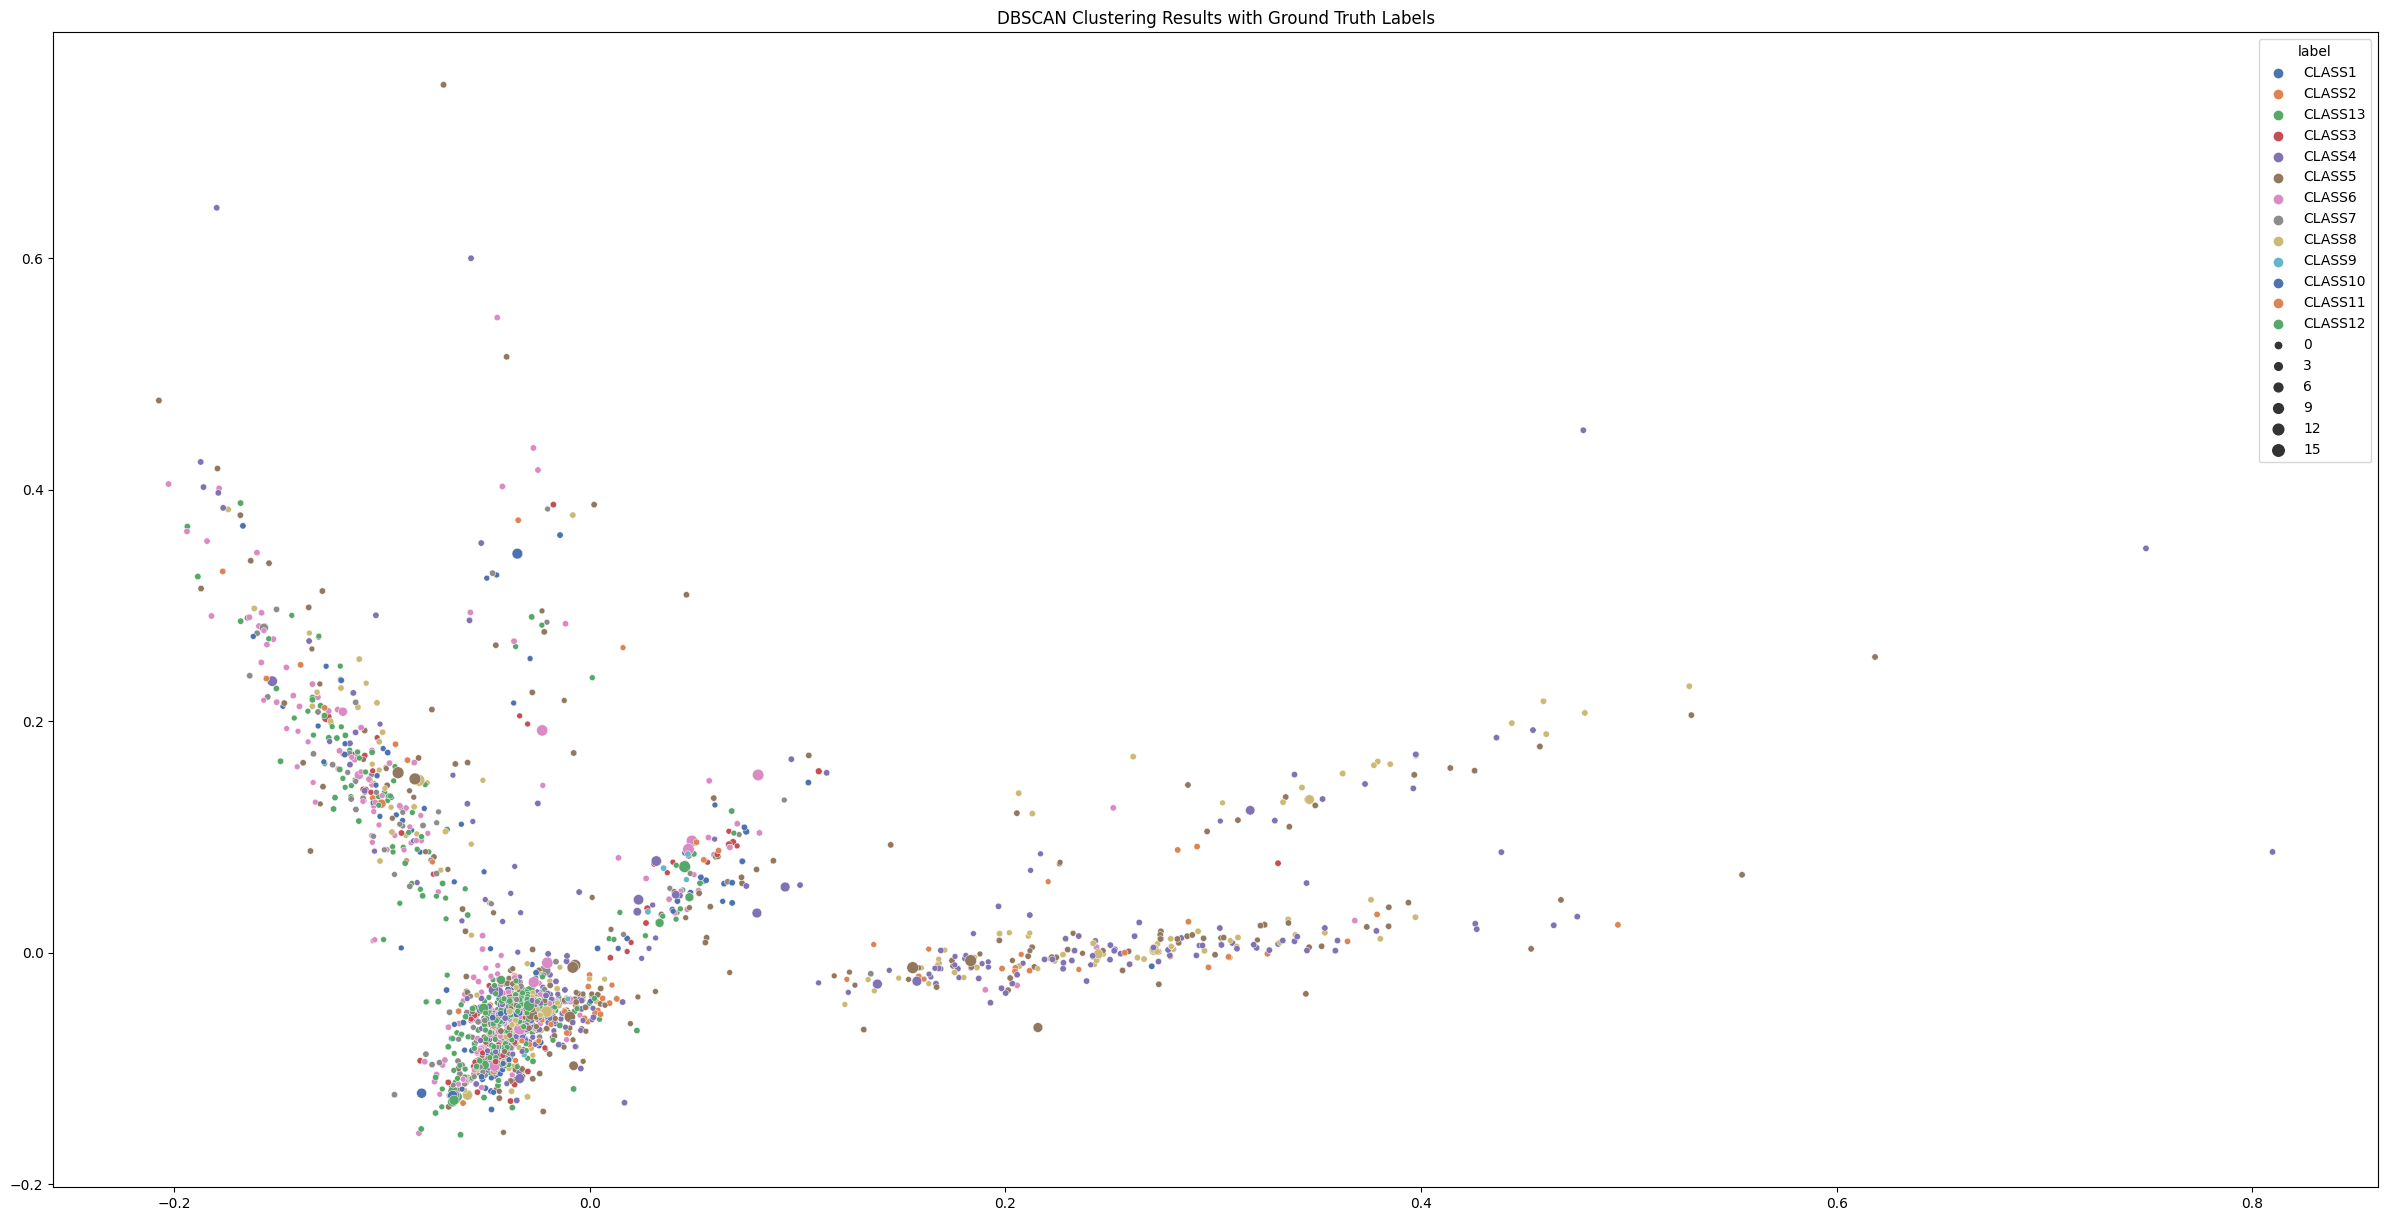

In [55]:

# Apply DBSCAN clustering
for dbscan_eps in [0.55]:
  db = DBSCAN(eps=dbscan_eps, metric='cosine' ,min_samples=5)
  labels = db.fit_predict(X)


  # Reduce dimensionality
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X.toarray())
  # Simply using PCA for plotting.

  # Assuming there's a list of ground truth labels
  ground_truth_labels = df['label']

  # Plot
  plt.figure(figsize=(30, 15))
  sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=ground_truth_labels, size=labels, palette="deep")
  plt.title("DBSCAN Clustering Results with Ground Truth Labels")
  plt.show()


##Looks like the data has some inherent separation but TFIDF is not good enough to create meaningful semantic separation in the data.

In [56]:

# This basic function is to tackle imbalance in the dataset,
# it upsamples classes with fewer examples and downsamples classes with more than the given number.
def balance_dataset(df, column_name='label', samples_per_class=50):

    balanced_df = pd.DataFrame()

    for label in df[column_name].unique():
        label_df = df[df[column_name] == label]

        if len(label_df) < samples_per_class:
            label_df = label_df.sample(samples_per_class, replace=True, random_state=42)
        else:
            label_df = label_df.sample(samples_per_class, random_state=42)

        balanced_df = balanced_df.append(label_df)

    return balanced_df.reset_index(drop=True)




##I treat the above function to create the train dataset as a ***hyperparameter***, i tried samples_per_class in the range of **[10,30,50,100]** i choose these numbers because i wanted to improve the classes which were doing poorly even with enough examples.


#Fine tuning experiments:
 - Chose DistilBert beacuse its fast
 - tokenizer for distillBERT has *Fast* version
 - Fastest finetuning as compared to other models


In [57]:



device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = len(df['label'].unique()))



model = model.to(device)
model




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [58]:
# Basic mapper function to map category(str) --> category(int)

c =  df['label'].astype('category')
d = dict(enumerate(c.cat.categories))
df['text_label'] = df['label']
df['label'] = df['label'].astype('category').cat.codes




In [59]:

d

{0: 'CLASS1',
 1: 'CLASS10',
 2: 'CLASS11',
 3: 'CLASS12',
 4: 'CLASS13',
 5: 'CLASS2',
 6: 'CLASS3',
 7: 'CLASS4',
 8: 'CLASS5',
 9: 'CLASS6',
 10: 'CLASS7',
 11: 'CLASS8',
 12: 'CLASS9'}

In [60]:
df['label'].value_counts()

4     489
7     373
8     300
9     263
11    225
10    168
1     119
6      94
2      81
0      76
5      40
12     28
3       3
Name: label, dtype: int64

In [61]:

tdf = df[df['label']!=3]


##This pesky class had only 3 examples so i simply dropped them from the train dataset

In [62]:
# Created the upsampled and downsampled training data to fine tune the model
ft_df = balance_dataset(df=tdf, column_name='label',samples_per_class=100)


# the rest of the data that is not seen by the model will be used as test dataset
test_df = df.merge(ft_df.drop_duplicates(), on=['label','clean_text'], how='left', indicator=True)[['label','clean_text','_merge']]


<ipython-input-56-4da96d19a5d0>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(label_df)
<ipython-input-56-4da96d19a5d0>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(label_df)
<ipython-input-56-4da96d19a5d0>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(label_df)
<ipython-input-56-4da96d19a5d0>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(label_df)
<ipython-input-56-4da96d19a5d0>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [63]:
test_df = test_df[test_df['_merge']=='left_only'].reset_index()[['label','clean_text']]

In [64]:
test_df

,label,clean_text
0,4,Communications Technician
1,6,Emergency Preparedness Officer
2,8,Coordinator IT Contract Services
3,9,2023 Video Production and Media Intern
4,8,Senior Manager Enterprise Applications
...,...,...
1318,7,Director RD Communications Japan
1319,11,Associate Director GRA QMS Quality
1320,7,Continuous Improvement Champion II
1321,4,Manager Global Evidence and Outcomes China Sha...


#Train-Validation Splitting here, pretty standard stuff from here on

In [65]:

X = df['clean_text'].to_list()
y = df['label'].to_list()

train_text, val_text, train_label, val_label = train_test_split(X,y, test_size=0.3, random_state=42)


#encoding data AKA wrangling data into a form which could be used by the Language model

In [66]:

train_encodings = tokenizer(train_text, truncation=True, padding=True,max_length=512)
val_encodings = tokenizer(val_text, truncation=True, padding=True,max_length=512)




# Create test encodings using test_df
test_texts = test_df['clean_text'].to_list()
test_label = test_df['label'].to_list()


test_encodings = tokenizer(test_texts, truncation=True, padding=True,max_length=512)

In [67]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

##Creating an object class by inheriting the toch.dataset class which is required to be passed into the LM.

In [68]:
class JobTitles(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
          item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [69]:

train_dat = JobTitles(encodings=train_encodings,labels=train_label)
val_dat = JobTitles(encodings=val_encodings,labels=val_label)

test_dat = JobTitles(encodings=test_encodings,labels=test_label)

In [70]:
print(len(train_dat.labels),len(train_dat.encodings))

1581 2


#Compute metrics for eval set

In [71]:


def compute_metrics(p):
  pred,labels = p
  pred = np.argmax(pred,axis=1)

  accuracy = accuracy_score(y_true=labels,y_pred =pred)
  # recall = recall_score(y_true=labels,y_pred =pred)
  classification = classification_report(y_true=labels,y_pred =pred)
  return({"overall":classification,"accuracy":accuracy})

#Used huggingface Tariner API for fine-tuning. Definitely made life easier rather than implementing training loop in pytorch

In [72]:


training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=7,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    learning_rate = 0.00005,
    weight_decay = 0.001
)

# model = AutoModelForSequenceClassification.from_pretrained(model_name)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dat,         # training dataset
    eval_dataset=val_dat,
    compute_metrics=compute_metrics   # evaluation dataset
)



In [73]:
trainer.train()

Step,Training Loss
500,0.923500


TrainOutput(global_step=693, training_loss=0.6998773384919931, metrics={'train_runtime': 93.5049, 'train_samples_per_second': 118.357, 'train_steps_per_second': 7.411, 'total_flos': 189015787191924.0, 'train_loss': 0.6998773384919931, 'epoch': 7.0})

In [74]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "              precision

{'eval_loss': 1.2753164768218994,
 'eval_overall': '              precision    recall  f1-score   support\n\n           0       0.94      0.77      0.85        22\n           1       0.78      0.78      0.78        40\n           2       0.53      0.48      0.50        21\n           3       0.00      0.00      0.00         1\n           4       0.67      0.70      0.68       147\n           5       0.78      0.78      0.78         9\n           6       0.62      0.43      0.51        23\n           7       0.70      0.83      0.76       116\n           8       0.65      0.65      0.65        89\n           9       0.74      0.71      0.72        83\n          10       0.70      0.59      0.64        44\n          11       0.61      0.59      0.60        71\n          12       1.00      0.83      0.91        12\n\n    accuracy                           0.69       678\n   macro avg       0.67      0.63      0.65       678\nweighted avg       0.69      0.69      0.69       678\n',
 'eval

In [86]:
import torch
import numpy as np

def get_prediction(text, device='cuda'):
    model.to(device)
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    predictions = np.argmax(probs.cpu().numpy(), axis=1)

    return predictions


In [87]:
temp = get_prediction(text="Senior Manager | Accounts")

In [88]:
temp

array([9])

In [89]:
d[temp[0]]

'CLASS6'

##Test Dataset Outputs

In [90]:
out = trainer.predict(test_dataset=test_dat)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Score and overall metrics on **TRAIN** Dataset
###Just to check if the model was trained properly

In [91]:
print(trainer.predict(test_dataset=train_dat)[2]['test_overall'])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        54
           1       0.98      1.00      0.99        79
           2       0.98      0.95      0.97        60
           3       0.00      0.00      0.00         2
           4       1.00      1.00      1.00       342
           5       0.97      0.97      0.97        31
           6       0.97      0.99      0.98        71
           7       1.00      1.00      1.00       257
           8       0.98      1.00      0.99       211
           9       0.98      0.99      0.99       180
          10       1.00      0.98      0.99       124
          11       0.99      0.99      0.99       154
          12       0.94      0.94      0.94        16

    accuracy                           0.99      1581
   macro avg       0.91      0.91      0.91      1581
weighted avg       0.99      0.99      0.99      1581



#Test Metrics, Looks good

In [92]:
print(out[2]['test_overall'])

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.73      1.00      0.84        19
           2       0.71      0.68      0.69        25
           3       0.00      0.00      0.00         3
           4       0.94      0.92      0.93       389
           5       0.25      0.50      0.33         2
           6       0.91      0.85      0.88        34
           7       0.91      0.95      0.93       273
           8       0.91      0.91      0.91       200
           9       0.92      0.91      0.91       163
          10       0.88      0.85      0.87        68
          11       0.85      0.85      0.85       125
          12       1.00      1.00      1.00         1

    accuracy                           0.90      1323
   macro avg       0.77      0.80      0.78      1323
weighted avg       0.90      0.90      0.90      1323



In [202]:
trainer.save_model("./assignment_orbit_MLC")

In [203]:

model = DistilBertForSequenceClassification.from_pretrained("./assignment_orbit_MLC/")

In [205]:
model.push_to_hub("pranay5255/assignment_orbitshift")

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pranay5255/assignment_orbitshift/commit/18065573645e0357076b86e4f6dadf18819b6c38', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='18065573645e0357076b86e4f6dadf18819b6c38', pr_url=None, pr_revision=None, pr_num=None)

#Sanity Check

In [55]:

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained("pranay5255/assignment_orbitshift")


In [57]:
d[get_prediction(text="Senior Manager | Accounts")[0]]

'CLASS6'